# Machine Bias
# 
"""
https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm

Context
COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges
and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm
is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed
crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable.

Quoting from ProPublica: 

Black defendants were often predicted to be at a higher risk of recidivism than they actually were. Our analysis found that black defendants
who did not recidivate over a two-year period were nearly twice as likely to be misclassified as higher risk compared to their white counterparts
(45 percent vs. 23 percent). White defendants were often predicted to be less risky than they were. Our analysis found that white defendants who
re-offended within the next two years were mistakenly labeled low risk almost twice as often as black re-offenders (48 percent vs. 28 percent).
The analysis also showed that even when controlling for prior crimes, future recidivism, age, and gender, black defendants were 45 percent more
likely to be assigned higher risk scores than white defendants.

Black defendants were also twice as likely as white defendants to be misclassified as being a higher risk of violent recidivism. And white violent
recidivists were 63 percent more likely to have been misclassified as a low risk of violent recidivism, compared with black violent recidivists.
The violent recidivism analysis also showed that even when controlling for prior crimes, future recidivism, age, and gender, black defendants were
77 percent more likely to be assigned higher risk scores than white defendants. "

Content
Data contains variables used by the COMPAS algorithm in scoring defendants, along with their outcomes within 2 years of the decision, for over
10,000 criminal defendants in Broward County, Florida. 3 subsets of the data are provided, including a subset of only violent
recividism (as opposed to, e.g. being reincarcerated for non violent offenses such as vagrancy or Marijuana).

Indepth analysis by ProPublica can be found in their data methodology article.



Each pretrial defendant received at least three COMPAS scores:  (DisplayText)
“Risk of Recidivism,”
“Risk of Violence” 
“Risk of Failure to Appear.”

COMPAS scores for each defendant ranged from1 to 10, with ten being the highest risk. Scores (ScoreTex)
1 to 4 were labeled by COMPAS as “Low”;
5 to 7 were labeled “Medium”; and
8 to 10 were labeled “High.”


Columns
0 - 4  : 'Person_ID','AssessmentID','Case_ID','Agency_Text', 'LastName',
5 - 9  : 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text','DateOfBirth',
10 - 14: 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason','Language', 'LegalStatus',
15 - 19: 'CustodyStatus', 'MaritalStatus','Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
20 - 24: 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
25 - 27: 'AssessmentType', 'IsCompleted', 'IsDeleted'

In [1]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# For preprocessing the data
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
# Standardizing
from sklearn.preprocessing import StandardScaler
# To split the dataset into train and test datasets
from sklearn.model_selection import train_test_split
# To calculate the accuracy score of the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#
from datetime import datetime
from datetime import date
#
import collections


In [2]:
# load dataset
pthfnm = "./compas-scores-raw.csv"
df = pd.read_csv(pthfnm)

In [3]:
# initial EDA
print(df.shape)
print(df.info())

(60843, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60843 entries, 0 to 60842
Data columns (total 28 columns):
Person_ID                  60843 non-null int64
AssessmentID               60843 non-null int64
Case_ID                    60843 non-null int64
Agency_Text                60843 non-null object
LastName                   60843 non-null object
FirstName                  60843 non-null object
MiddleName                 15648 non-null object
Sex_Code_Text              60843 non-null object
Ethnic_Code_Text           60843 non-null object
DateOfBirth                60843 non-null object
ScaleSet_ID                60843 non-null int64
ScaleSet                   60843 non-null object
AssessmentReason           60843 non-null object
Language                   60843 non-null object
LegalStatus                60843 non-null object
CustodyStatus              60843 non-null object
MaritalStatus              60843 non-null object
Screening_Date             60843 non-null object
R

In [4]:
# Review data and Manipulate Data

# Ethnic_Code_Text
print(df.Ethnic_Code_Text.unique())

['Caucasian' 'African-American' 'Hispanic' 'Other' 'Asian' 'African-Am'
 'Native American' 'Oriental' 'Arabic']


In [5]:
# update 'Ethnic_Code_Text' to have conistent values for African Americans
df.loc[df['Ethnic_Code_Text'] == 'African-Am', 'Ethnic_Code_Text'] = 'African-American'
print(pd.value_counts(df['Ethnic_Code_Text']))

African-American    27069
Caucasian           21783
Hispanic             8742
Other                2592
Asian                 324
Native American       219
Arabic                 75
Oriental               39
Name: Ethnic_Code_Text, dtype: int64


In [6]:
# DecileScore should be between 1 & 10, delete otherwise
df.DecileScore.unique()
print((df['DecileScore'] < 1).sum())

45


In [7]:
# remove DecileScore < 1
df = df[df.DecileScore >= 1]
print(pd.value_counts(df['DecileScore']))

1     18465
2      9192
3      8492
4      5338
5      4831
6      4319
7      3338
8      2799
9      2386
10     1638
Name: DecileScore, dtype: int64


In [8]:
# Add column 'Age' from DateofBirth
agelist = []
currdate = date.today()
for dte in df['DateOfBirth']:
    brthdte = datetime.strptime(dte, '%m/%d/%y')
    mnthday = (currdate.month, currdate.day) < (brthdte.month, brthdte.day)
    if currdate.year > brthdte.year:
        agelist.append(currdate.year - brthdte.year - (mnthday))
    else:
        agelist.append(-1)
        

In [9]:
print(len(agelist), len(df))
df['Age'] = agelist
print(df.columns)

60798 60798
Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted', 'Age'],
      dtype='object')


In [10]:
# cleanup bad Ages
# remove DecileScore < 1
(df['Age'] < 1).sum()

12782

In [11]:
df = df[df.Age >= 1]
(df['Age'] < 1).sum()

0

In [12]:
df['Age'].describe()

count    48016.000000
mean        32.949850
std          7.187846
min         20.000000
25%         27.000000
50%         32.000000
75%         38.000000
max         49.000000
Name: Age, dtype: float64

In [13]:
# slice and dice

# Slice by 'Ethnic_Code_Text' for blacks & whites
black = df.loc[df['Ethnic_Code_Text'] == 'African-American']
white = df.loc[df['Ethnic_Code_Text'] == 'Caucasian']
joint = df.loc[df['Ethnic_Code_Text'].isin (['Caucasian','African-American'])]
print('black :', black.shape, ' white: ', white.shape, ' joint: ', joint.shape)

black : (23169, 29)  white:  (15290, 29)  joint:  (38459, 29)


In [14]:
# Slice by 'Sex_Code_Text' for males & females
male = df.loc[df['Sex_Code_Text'] == 'Male']
female = df.loc[df['Sex_Code_Text'] == 'Female']
print('male :', male.shape, ' female: ', female.shape)

male : (37308, 29)  female:  (10708, 29)


In [15]:
# Slice by 'DisplayText' for Risk
RiskAppear = df.loc[df['DisplayText'] == 'Risk of Failure to Appear']
RiskViolence = df.loc[df['DisplayText'] == 'Risk of Violence']
RiskRecidivism = df.loc[df['DisplayText'] == 'Risk of Recidivism']
print('Appear:', RiskAppear.shape, ' Violence: ', RiskViolence.shape,  ' Recidivism:',RiskRecidivism.shape)

Appear: (16016, 29)  Violence:  (16010, 29)  Recidivism: (15990, 29)


In [16]:
# Aggregate
grprace = df.groupby(['Ethnic_Code_Text']).count()
grpgender = df.groupby(['Sex_Code_Text']).count()
print('Race: ',grprace.shape, ' Gender:', grpgender.shape)

Race:  (8, 28)  Gender: (2, 28)


# Looking at some bias in the data set by Ethncity and sex

In [17]:
## Display distribution of group data
# % data distribution by Ethnic_Code_Text
round(grprace[['DecileScore']]/len(df),4)*100

,DecileScore
Ethnic_Code_Text,
African-American,48.25
Arabic,0.12
Asian,0.48
Caucasian,31.84
Hispanic,14.60
Native American,0.39
Oriental,0.07
Other,4.25


In [ ]:
# There are more African Americans (48%) in the dataset, eventhough in the county African American only make 
# up (30%) of the population

In [18]:
# % data distribution by Sex_Code_Text
round(grpgender[['DecileScore']]/len(df),4)*100


,DecileScore
Sex_Code_Text,
Female,22.3
Male,77.7


In [ ]:
# There are more males (78%) in the dataset, eventhough in the county males make 
# up (49%) of the population

In [19]:
# DecileScore Mean by race
race=df.Ethnic_Code_Text.unique()
print('Mean DecileScore by Race')
for i in race:
    mn = round(df.loc[df['Ethnic_Code_Text'] == i]['DecileScore'].mean(), 2)
    print(i,'- ',mn)

Mean DecileScore by Race
Caucasian -  3.49
African-American -  4.44
Hispanic -  3.1
Other -  2.77
Asian -  2.66
Native American -  4.15
Oriental -  2.91
Arabic -  3.58


In [ ]:
# Mean DecileScore is highest for African Americans

In [20]:
# DecileScore Mean by gender
gender=df.Sex_Code_Text.unique()
print('Mean DecileScore by Gender')
for i in gender:
    mn = round(df.loc[df['Sex_Code_Text'] == i]['DecileScore'].mean(), 2)
    print(i,'- ',mn)

Mean DecileScore by Gender
Male -  3.95
Female -  3.53


In [ ]:
# Mean DecileScore is highest for males

In [ ]:
# Visualize

In [21]:
# Define grp_plot_compare:
# creates groups and then plot them to compare them
def grp_plot_compare(df1, df2, xlabel1, colnm1, total_pop, multby, title,label1, label2):
    grp1 = df1.groupby([xlabel1]).count()
    grp2 = df2.groupby([xlabel1]).count()
    
#   to be used for weighted average  
    div1 = len(df1)
    div2 = len(df2)
    
    n_groups = len(grp1)
# create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(grp1.index,(round(grp1[colnm1]/div1,2)*multby), bar_width,
                 alpha=opacity,
                 color='b',
                 label=label1)

    rects2 = plt.bar(grp2.index+ bar_width, (round(grp2[colnm1]/div2,2)*multby), bar_width,
                 alpha=opacity,
                 color='g',
                 label=label2)

    plt.xlabel(xlabel1)
    if total_pop > 1:
        plt.ylabel('Percentage')
    else:
        plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.clf()

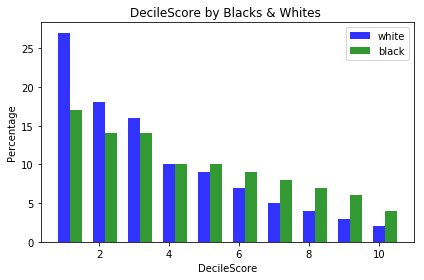

In [22]:
# Comparing White & Black defendants on the  'DecileScore'
grp_plot_compare(white, black, 'DecileScore','Ethnic_Code_Text', len(df), 100, \
                 'DecileScore by Blacks & Whites ', \
                 'white','black')

In [ ]:
# Whites have lower Decile Scores and Blacks have higher Decile Scores

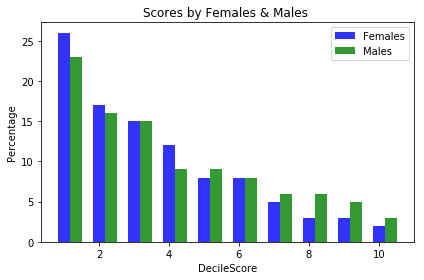

In [23]:
# Comparing Male & Female defendants on the  'DecileScore'
grp_plot_compare(female, male, 'DecileScore','Sex_Code_Text', len(df), 100, \
                 'Scores by Females & Males ', \
                 'Females','Males')


In [ ]:
# Females have lower Decile Scores and Males have higher Decile Scores

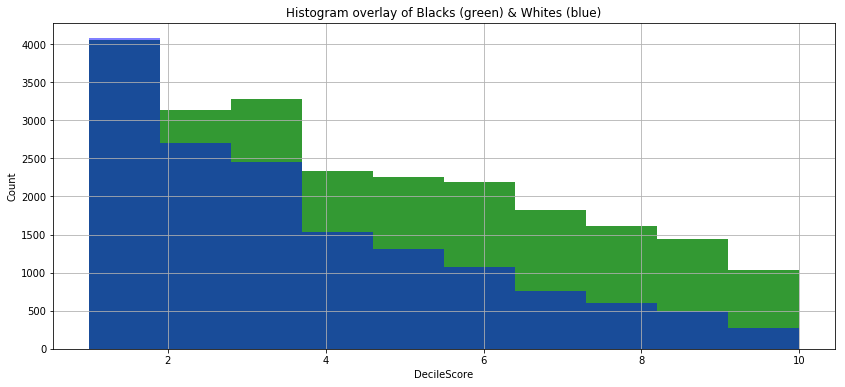

In [24]:
####################################################################################
# Histogram overlay
fig, ax = plt.subplots()
black['DecileScore'].hist(bins=10, figsize=[14,6],color='g',alpha=.8 )
white['DecileScore'].hist(bins=10, figsize=[14,6],color='b',alpha=.5 )
plt.title('Histogram overlay of Blacks (green) & Whites (blue)')
plt.legend()
plt.xlabel('DecileScore')
plt.ylabel('Count')
plt.show()
plt.clf()

# Running ML models

In [25]:
# Define prepare_data_for_ml_model_1:
def prepare_data_for_ml_model_1(dfx, target_loc):
    # Create new DataFrame of selected columns
     
    """
    Columns
    0 - 4  : 'Person_ID','AssessmentID','Case_ID','Agency_Text', 'LastName',
    5 - 9  : 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text','DateOfBirth',
    10 - 14: 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason','Language', 'LegalStatus',
    15 - 19: 'CustodyStatus', 'MaritalStatus','Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
    20 - 24: 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
    25 - 28: 'AssessmentType', 'IsCompleted', 'IsDeleted','Age'
    """
    """
    race, age, criminal history, future recidivism, charge degree, gender and age.
    """
    # slice for subset data features and targets
    df_new = dfx.iloc[:, [7,8,14,15,16,19,28]] #features
    y = dfx.iloc[:,target_loc] #target

    
    #  One-Hot encoder. It encodes the data into binary format
    le = preprocessing.LabelEncoder()

    Sex_Code_Text_cat = le.fit_transform(df_new.Sex_Code_Text)
    Ethnic_Code_Text_cat = le.fit_transform(df_new.Ethnic_Code_Text)
    LegalStatus_cat = le.fit_transform(df_new.LegalStatus)
    CustodyStatus_cat = le.fit_transform(df_new.CustodyStatus)
    MaritalStatus_cat = le.fit_transform(df_new.MaritalStatus)
    RecSupervisionLevelText_cat = le.fit_transform(df_new.RecSupervisionLevelText) 
 
    df_new['Sex_Code_Text_cat'] = Sex_Code_Text_cat
    df_new['Ethnic_Code_Text_cat'] = Ethnic_Code_Text_cat
    df_new['LegalStatus_cat'] = LegalStatus_cat
    df_new['CustodyStatus_cat'] = CustodyStatus_cat
    df_new['MaritalStatus_cat'] = MaritalStatus_cat
    df_new['RecSupervisionLevelText_cat'] = RecSupervisionLevelText_cat



    #drop the old categorical columns from dataframe

    dummy_fields = ['Sex_Code_Text',
                  'Ethnic_Code_Text',  'LegalStatus', 'CustodyStatus',
                  'MaritalStatus','RecSupervisionLevelText' ]
    

    df_new = df_new.drop(dummy_fields, axis = 1)
    print('columns:',df_new.columns)

    # Standardizing
    #X_std = StandardScaler().fit_transform(X_rev)


    # Split data train and test, first import library
    X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.2)
    print('Length for X_train:', len(X_train), ' X_test:',len(X_test), ' y_train:',len(y_train) ,' y_test:',len(y_test))

    return X_train, X_test, y_train, y_test


In [26]:
# Define ml_model_1:
# takes in model Instantiate model (model)
# fits, predicts, and evaluates (prints results)
def ml_model_1(model, modelnm, dfnm, X_train, X_test, y_train, y_test, target):
    print('Running ', modelnm, ' model for :', dfnm, ' using target: ', target)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Evaluate
    print(modelnm,' score: ',model.score(X_test, y_test))
    print(' ')
    print('first 10 predicted values: ',y_pred[0:10])
    print('first 10 values of target: ')
    print(y_test.head(10))
    print(' ')

    print('mean of predicted of values: ',np.mean(y_pred), ' STD of predicted of values : ', np.std(y_pred) )
    print('describe of target')
    print(y_test.describe())

    return y_pred

In [ ]:
# MLPRegressor

In [27]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(alpha=0.001, hidden_layer_sizes = (10,), max_iter = 50000, 
                 activation = 'logistic', verbose = 'True', learning_rate = 'adaptive')

In [28]:
# MLPRegressor - RiskViolence dataset target RawScore (22)
# Preparing the data
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskViolence,22)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 12808  X_test: 3202  y_train: 12808  y_test: 3202


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [29]:
# Predicting and getting score
ml_model_1(clf, 'MLPRegressor', 'RiskViolence', X_train, X_test, y_train, y_test, 'RawScore')

Running  MLPRegressor  model for : RiskViolence  using target:  RawScore
Iteration 1, loss = 2.57075474
Iteration 2, loss = 1.35167946
Iteration 3, loss = 0.43336228
Iteration 4, loss = 0.29861297
Iteration 5, loss = 0.27943571
Iteration 6, loss = 0.26387229
Iteration 7, loss = 0.24982849
Iteration 8, loss = 0.23357787
Iteration 9, loss = 0.21584765
Iteration 10, loss = 0.20348476
Iteration 11, loss = 0.19429114
Iteration 12, loss = 0.18747223
Iteration 13, loss = 0.18203836
Iteration 14, loss = 0.17744479
Iteration 15, loss = 0.17363013
Iteration 16, loss = 0.17046117
Iteration 17, loss = 0.16786487
Iteration 18, loss = 0.16569671
Iteration 19, loss = 0.16385280
Iteration 20, loss = 0.16227297
Iteration 21, loss = 0.16101371
Iteration 22, loss = 0.15935204
Iteration 23, loss = 0.15812210
Iteration 24, loss = 0.15678398
Iteration 25, loss = 0.15550778
Iteration 26, loss = 0.15435694
Iteration 27, loss = 0.15270251
Iteration 28, loss = 0.15100390
Iteration 29, loss = 0.14940425
Iteratio

array([-1.54026987, -2.44516306, -2.52255805, ..., -3.31121711,
       -1.82777074, -2.32550932])

In [ ]:
# MLPRegressor  score:  0.8027709017197646

In [30]:
# MLPRegressor - RiskRecidivism dataset target RawScore (22)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,22)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [31]:
# Predicting and getting score
ml_model_1(clf, 'MLPRegressor', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'RawScore')

Running  MLPRegressor  model for : RiskRecidivism  using target:  RawScore
Iteration 1, loss = 0.41842957
Iteration 2, loss = 0.29270101
Iteration 3, loss = 0.24702363
Iteration 4, loss = 0.22433292
Iteration 5, loss = 0.21147496
Iteration 6, loss = 0.20315780
Iteration 7, loss = 0.19768554
Iteration 8, loss = 0.19358528
Iteration 9, loss = 0.19034151
Iteration 10, loss = 0.18787049
Iteration 11, loss = 0.18537620
Iteration 12, loss = 0.18288852
Iteration 13, loss = 0.17991468
Iteration 14, loss = 0.17670857
Iteration 15, loss = 0.17306491
Iteration 16, loss = 0.16917553
Iteration 17, loss = 0.16477607
Iteration 18, loss = 0.16012081
Iteration 19, loss = 0.15475526
Iteration 20, loss = 0.14884879
Iteration 21, loss = 0.14219008
Iteration 22, loss = 0.13542189
Iteration 23, loss = 0.12873640
Iteration 24, loss = 0.12240455
Iteration 25, loss = 0.11586731
Iteration 26, loss = 0.11012900
Iteration 27, loss = 0.10495653
Iteration 28, loss = 0.09977685
Iteration 29, loss = 0.09518898
Iterat

array([-0.37503614, -1.10831782, -0.87651244, ..., -0.32543266,
       -0.21957393,  0.11252159])

In [ ]:
# MLPRegressor  score: 0.7810058734617599

In [32]:
#  Running again but using DecileScore as the target
# MLPRegressor - RiskRecidivism dataset target DecileScore (23)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,23)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [34]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(alpha=0.001, hidden_layer_sizes = (10,), max_iter = 50000, 
                 activation = 'logistic', verbose = 'True', learning_rate = 'adaptive')

In [35]:
# Predicting and getting score
y_pred_MLPR = ml_model_1(clf, 'MLPRegressor', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'DecileScore')

Running  MLPRegressor  model for : RiskRecidivism  using target:  DecileScore
Iteration 1, loss = 11.78775294
Iteration 2, loss = 9.21958446
Iteration 3, loss = 7.69955060
Iteration 4, loss = 6.59796895
Iteration 5, loss = 5.77993157
Iteration 6, loss = 5.17883421
Iteration 7, loss = 4.74746191
Iteration 8, loss = 4.44528761
Iteration 9, loss = 4.24121745
Iteration 10, loss = 4.10702135
Iteration 11, loss = 4.02230069
Iteration 12, loss = 3.97020988
Iteration 13, loss = 3.93959344
Iteration 14, loss = 3.92222898
Iteration 15, loss = 3.91265495
Iteration 16, loss = 3.90777043
Iteration 17, loss = 3.90513815
Iteration 18, loss = 3.90371857
Iteration 19, loss = 3.90305097
Iteration 20, loss = 3.90262280
Iteration 21, loss = 3.90194459
Iteration 22, loss = 3.82547197
Iteration 23, loss = 3.69124297
Iteration 24, loss = 3.59025562
Iteration 25, loss = 3.50775103
Iteration 26, loss = 3.43817124
Iteration 27, loss = 3.37879564
Iteration 28, loss = 3.32651485
Iteration 29, loss = 3.28007130
It

Iteration 256, loss = 0.65038393
Iteration 257, loss = 0.65009711
Iteration 258, loss = 0.64875851
Iteration 259, loss = 0.64744780
Iteration 260, loss = 0.64846323
Iteration 261, loss = 0.64820546
Iteration 262, loss = 0.64779234
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
MLPRegressor  score:  0.8319946400998878
 
first 10 predicted values:  [6.0084011  9.06406658 9.30839838 2.97928132 6.60020398 5.13320797
 2.94352241 2.40648588 5.7049092  9.13720043]
first 10 values of target: 
14212     6
39214     9
1645      9
44221     4
19546     7
25141     4
55531     3
26647     3
42871     7
18631    10
Name: DecileScore, dtype: int64
 
mean of predicted of values:  4.78076602612445  STD of predicted of values :  2.5263634973759888
describe of target
count    3198.000000
mean        4.842402
std         2.738674
min         1.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: DecileScore, dtype: fl

In [ ]:
# MLPRegressor  score:  0.8319946400998878

# Test Bias by substituting 'Caucasian' to 'African-American' in the RiskRecidivism dataset

In [36]:
# getting subset data from RiskRecidivism dataset
whiteRR = RiskRecidivism.loc[RiskRecidivism['Ethnic_Code_Text'] == 'Caucasian']
blackRR = RiskRecidivism.loc[RiskRecidivism['Ethnic_Code_Text'] == 'Caucasian']

In [53]:
# getting subset data from RiskRecidivism dataset
whiteRR = RiskRecidivism.loc[RiskRecidivism['Ethnic_Code_Text'] == 'Caucasian']
blackRR = RiskRecidivism.loc[RiskRecidivism['Ethnic_Code_Text'] == 'African-American']

In [37]:
# substituting 'Caucasian' to 'African-American' in the dataset
blackRR.loc[blackRR['Ethnic_Code_Text'] != 'African-American', 'Ethnic_Code_Text'] = 'African-American'

C:\Users\rivas\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
# Validating data
pd.value_counts(whiteRR['Ethnic_Code_Text'])

Caucasian    5092
Name: Ethnic_Code_Text, dtype: int64

In [39]:
pd.value_counts(blackRR['Ethnic_Code_Text'])

African-American    5092
Name: Ethnic_Code_Text, dtype: int64

In [54]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(alpha=0.001, hidden_layer_sizes = (10,), max_iter = 50000, 
                 activation = 'logistic', verbose = 'True', learning_rate = 'adaptive')

In [ ]:
# Using the DecileScore for the target

In [55]:
# Prepare data for model for RiskRecidivism dataset and Decile Score for Target
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,23)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [56]:
# Prepare data for model for whiteRR dataset 
Xwht_train, Xwht_test, ywht_train, ywht_test =  prepare_data_for_ml_model_1(whiteRR,23)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 4073  X_test: 1019  y_train: 4073  y_test: 1019


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [57]:
# Prepare data for model for blackRR dataset 
Xblk_train, Xblk_test, yblk_train, yblk_test = prepare_data_for_ml_model_1(blackRR,23)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 6173  X_test: 1544  y_train: 6173  y_test: 1544


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
# Using MLPRegressor using the RiskRecidivism  training data
clf.fit(X_train, y_train)

Iteration 1, loss = 12.63920810
Iteration 2, loss = 9.78284394
Iteration 3, loss = 7.35773799
Iteration 4, loss = 6.37894617
Iteration 5, loss = 5.70048607
Iteration 6, loss = 5.00850539
Iteration 7, loss = 4.32150505
Iteration 8, loss = 4.09223195
Iteration 9, loss = 3.97759169
Iteration 10, loss = 3.91739161
Iteration 11, loss = 3.88672338
Iteration 12, loss = 3.87111742
Iteration 13, loss = 3.86349723
Iteration 14, loss = 3.85732019
Iteration 15, loss = 3.82577161
Iteration 16, loss = 3.60962772
Iteration 17, loss = 3.48058386
Iteration 18, loss = 3.39851344
Iteration 19, loss = 3.33861617
Iteration 20, loss = 3.29143743
Iteration 21, loss = 3.24992676
Iteration 22, loss = 3.21436068
Iteration 23, loss = 3.17968292
Iteration 24, loss = 3.14859466
Iteration 25, loss = 3.11922178
Iteration 26, loss = 3.09060809
Iteration 27, loss = 3.06308531
Iteration 28, loss = 3.03807961
Iteration 29, loss = 3.01278013
Iteration 30, loss = 2.98971368
Iteration 31, loss = 2.96827329
Iteration 32, lo

MLPRegressor(activation='logistic', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=50000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose='True', warm_start=False)

In [59]:
# Predict for whiteRR dataset 
ywht_pred = clf.predict(Xwht_test)

In [60]:
# Predict for blackRR dataset 
yblk_pred = clf.predict(Xblk_test)

In [61]:
# rounding predicted results and converting into integers
rndwht = (np.round(ywht_pred,0)).astype(int)

In [62]:
rndblk = (np.round(yblk_pred,0)).astype(int)

In [63]:
# comparing results
collections.Counter(y_test) # base test target

Counter({1: 431,
         2: 427,
         3: 396,
         4: 353,
         5: 329,
         6: 289,
         7: 272,
         8: 259,
         9: 252,
         10: 190})

In [64]:
collections.Counter(rndwht)    # white predict

Counter({2: 179, 3: 493, 4: 19, 5: 8, 6: 124, 7: 56, 8: 66, 9: 71, 10: 3})

In [65]:
collections.Counter(rndblk)    # black predict

Counter({2: 159, 3: 495, 4: 22, 5: 2, 6: 23, 7: 324, 8: 319, 9: 200})

In [67]:
blackRR2 = whiteRR


In [69]:
# substituting 'Caucasian' to 'African-American' in the dataset
blackRR2.loc[blackRR2['Ethnic_Code_Text'] != 'African-American', 'Ethnic_Code_Text'] = 'African-American'

C:\Users\rivas\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [70]:
# Prepare data for model for blackRR dataset 
Xblk2_train, Xblk2_test, yblk2_train, yblk2_test = prepare_data_for_ml_model_1(blackRR2,23)

C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

columns: Index(['Age', 'Sex_Code_Text_cat', 'Ethnic_Code_Text_cat', 'LegalStatus_cat',
       'CustodyStatus_cat', 'MaritalStatus_cat',
       'RecSupervisionLevelText_cat'],
      dtype='object')
Length for X_train: 4073  X_test: 1019  y_train: 4073  y_test: 1019


C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
# Predict for blackRR2 dataset 
yblk2_pred = clf.predict(Xblk2_test)

In [73]:
rndblk2 = (np.round(yblk2_pred,0)).astype(int)

In [74]:
collections.Counter(rndblk2)    # black2 predict

Counter({2: 159, 3: 516, 4: 19, 5: 6, 6: 94, 7: 63, 8: 76, 9: 83, 10: 3})